# Classification of Youtube Videos according to whether Views are Above Mean from number of Likes and Comments

## 0. Settings

### 0.1. Parameters

In [34]:
file_path = './videos-with-comments-aggr-norm.csv'
feature_names = ['likes', 'comments']
target_name = 'above_mean_views'
scoring = ['accuracy', 'f1', 'precision', 'recall', 'jaccard', 'roc_auc']
main_scoring = 'accuracy'
random_seed = 0

### 0.1. Libraries

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
sns.set()

## 1. Data

### 1.1 Loading feature and target data

In [36]:
full = pd.read_csv(file_path, usecols=feature_names+[target_name])

In [37]:
features = full[[feature_names[0], feature_names[1]]]
features.describe()

,likes,comments
count,1881.000000,1881.000000
mean,0.010379,0.010742
std,0.048386,0.051662
min,0.000000,0.000000
25%,0.000165,0.000273
50%,0.000920,0.001119
75%,0.003771,0.004663
max,1.000000,1.000000


In [38]:
target = full[target_name]
target.value_counts(normalize=True)

False    0.900053
True     0.099947
Name: above_mean_views, dtype: float64

### 1.2. Splitting training and testing datasets

In [39]:
train, test, train_features,  test_features, train_target, test_target = train_test_split(full, features, target, random_state=random_seed)
train.name, test.name, train_features.name, test_features.name, train_target.name, test_target.name = 'Training set', 'Testing set','Training set', 'Testing set', 'Training set', 'Testing set'

### 1.3. Scatterplot of Features grouped by Target

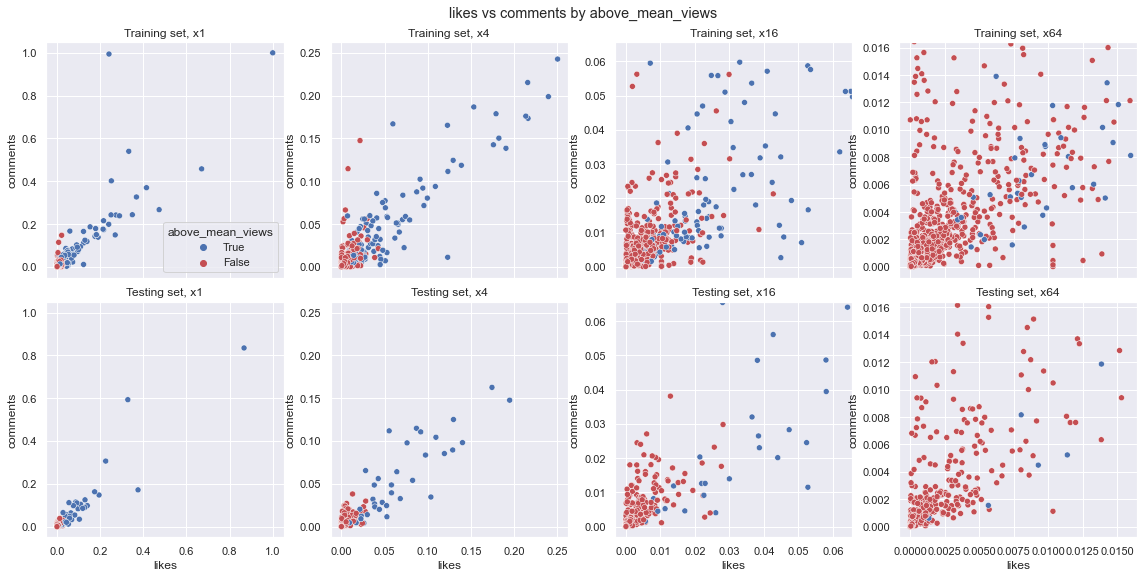

In [18]:
data = [train, test]
ax_limit = np.array([-0.05, 1.05])
zoom = [1,4,16,64]
n_row, n_col = len(data), len(zoom)
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4), sharex='col')
fig.suptitle('{} vs {} by {}'.format(feature_names[0], feature_names[1], target_name))
plt.tight_layout(pad=1.2)
for row in range(n_row):
    for col in range(n_col): 
        ax = axes[row][col]
        sns.scatterplot(x=feature_names[0], y=feature_names[1], 
                        hue=target_name, palette=['b','r'], hue_order=[True,False],
                        data=data[row], ax=ax)
        ax.set(xlim=ax_limit/zoom[col], ylim=ax_limit/zoom[col])
        ax.set_title('{}, x{}'.format(data[row].name, zoom[col]))
        if col > 0 or row > 0:
            ax.legend().set_visible(False)
plt.show()

## 2. K-Nearest Neighbors

In [30]:
model = KNeighborsClassifier()
metric = ['euclidean', 'manhattan', 'minkowski']
n_neighbors =  np.array(range(0, 200, 20))
n_neighbors[0] = 1
weights = ['uniform', 'distance']

param_grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, 
                           scoring=scoring, error_score=0, refit=main_scoring) #, return_train_score=True
grid_search = grid_search.fit(train_features, train_target.values.ravel())

In [25]:
knn_result = pd.DataFrame(grid_search.cv_results_)
knn_result = knn_result[['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_accuracy', 'rank_test_accuracy', 
                         'mean_test_f1', 'rank_test_f1', 'mean_test_precision', 'rank_test_precision', 'mean_test_recall', 
                         'rank_test_recall', 'mean_test_jaccard', 'rank_test_jaccard', 'mean_test_roc_auc','rank_test_roc_auc']]
knn_result.rename(columns={'param_metric': 'Metric', 'param_n_neighbors': 'N_Neighbors', 'param_weights': 'Weights', 
                           'mean_test_accuracy' : 'Accuracy', 'rank_test_accuracy' : 'Rank_Accuracy', 'mean_test_f1':'F1', 'rank_test_f1':'Rank_F1', 
                           'mean_test_precision':'Precision', 'rank_test_precision':'Rank_Precision', 'mean_test_recall':'Recall', 'rank_test_recall':'Rank_Recall', 
                           'mean_test_jaccard':'Jaccard', 'rank_test_jaccard':'Rank_Jaccard', 'mean_test_roc_auc':'ROC_AUC', 'rank_test_roc_auc':'Rank_ROC_AUC'}, inplace=True)
knn_result.sort_values('Rank_Accuracy').head(10)

,Metric,N_Neighbors,Weights,Accuracy,Rank_Accuracy,F1,Rank_F1,Precision,Rank_Precision,Recall,Rank_Recall,Jaccard,Rank_Jaccard,ROC_AUC,Rank_ROC_AUC
2,euclidean,20,uniform,0.956028,1,0.752070,3,0.856224,44,0.677340,4,0.610195,3,0.970645,51
42,minkowski,20,uniform,0.956028,1,0.752070,3,0.856224,44,0.677340,4,0.610195,3,0.970645,51
43,minkowski,20,distance,0.954610,3,0.755343,1,0.825794,53,0.698522,1,0.612897,1,0.971358,49
3,euclidean,20,distance,0.954610,3,0.755343,1,0.825794,53,0.698522,1,0.612897,1,0.971358,49
23,manhattan,20,distance,0.954610,3,0.751681,5,0.837722,52,0.684729,3,0.608241,5,0.969512,53
44,minkowski,40,uniform,0.953901,6,0.733996,10,0.871165,40,0.642611,16,0.587230,10,0.973359,38
4,euclidean,40,uniform,0.953901,6,0.733996,10,0.871165,40,0.642611,16,0.587230,10,0.973359,38
5,euclidean,40,distance,0.953901,6,0.743973,6,0.842743,50,0.670443,10,0.598682,6,0.973798,29
45,minkowski,40,distance,0.953901,6,0.743973,6,0.842743,50,0.670443,10,0.598682,6,0.973798,29
27,manhattan,60,distance,0.953901,6,0.732134,12,0.871752,39,0.635714,20,0.586044,12,0.974047,20


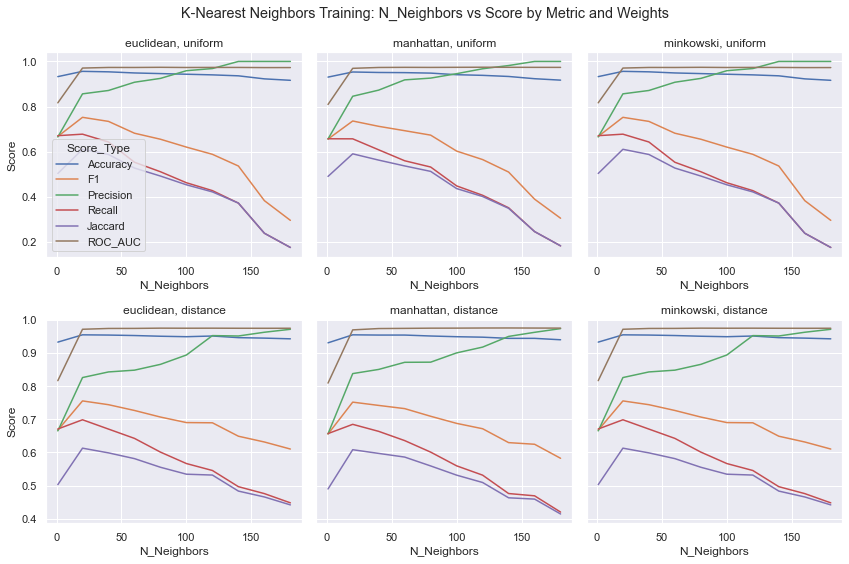

In [26]:
data = knn_result[['Metric', 'N_Neighbors', 'Weights', 'Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard', 'ROC_AUC']]
data = data.melt(id_vars=['Metric', 'N_Neighbors', 'Weights'], var_name='Score_Type', value_name='Score')

n_row, n_col = len(weights), len(metric)
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4), sharey='row')
fig.suptitle('K-Nearest Neighbors Training: N_Neighbors vs Score by Metric and Weights')
for row in range(n_row):
    for col in range(n_col):
        ax = axes[row][col]
        sns.lineplot(x='N_Neighbors', y='Score', hue='Score_Type', 
                     data=data.loc[(data.Metric==metric[col]) & (data.Weights==weights[row])], ax=ax)
        ax.set_title('{}, {}'.format(metric[col], weights[row])) 
        if col > 0 or row > 0:
            ax.legend().set_visible(False)
#axes[0][3].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(pad=1.2)
plt.show()

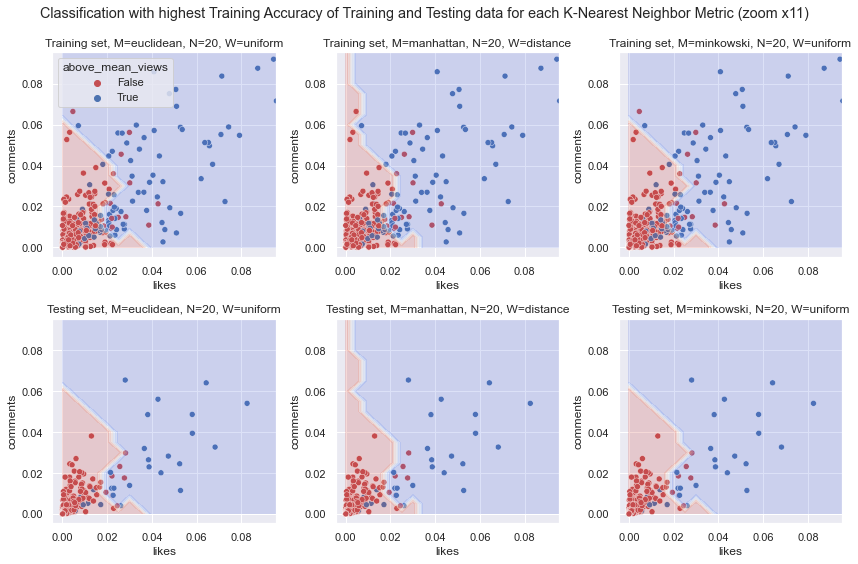

In [29]:
data = [train, test]
best_param_by_metric = knn_result.loc[knn_result.groupby('Metric')['Accuracy'].idxmax()]
mesh_density = .005
zoom = 11

n_row, n_col = len(data), len(metric)
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4))
fig.suptitle('K-Nearest Neighbor Classification with highest Training Accuracy of Training and Testing data for each Metric (zoom x{})'.format(zoom))
for col in range(n_col):
    parameter = best_param_by_metric .iloc[col]
    ml = KNeighborsClassifier(metric=parameter.Metric, n_neighbors=parameter.N_Neighbors, weights=parameter.Weights)
    ml.fit(train_features.values, train_target.values.ravel())
    for row in range(n_row):
        ax = axes[row][col]
        sns.scatterplot(x=feature_names[0], y=feature_names[1], 
                        hue=target_name, palette={True:'b', False:'r'},
                        data=data[row], ax=ax)
        x_min, x_max = train_features[feature_names[0]].min() , train_features[feature_names[0]].max() 
        y_min, y_max = train_features[feature_names[1]].min(), train_features[feature_names[1]].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_density), np.arange(y_min, y_max, mesh_density))
        decision_area = ml.predict(np.c_[xx.ravel(), yy.ravel()])
        decision_area = decision_area.reshape(xx.shape)
        ax.contourf(xx, yy, decision_area, cmap=plt.cm.coolwarm_r, alpha=0.2)
        ax.set(xlim=ax_limit/zoom, ylim=ax_limit/zoom)
        ax.set_title('{}, M={}, N={}, W={}'.format(data[row].name, parameter.Metric, 
                                                  parameter.N_Neighbors, parameter.Weights))
        if col > 0 or row > 0: 
            ax.legend().set_visible(False)
plt.tight_layout(pad=1.2)
plt.show()

## 3. Random Forest

In [47]:
model = RandomForestClassifier()
criterion = ['gini', 'log_loss', 'entropy'] 
n_estimators =  np.array(range(0, 200, 20))
n_estimators[0] = 1
max_features = ['sqrt', 'log2', None]

param_grid = dict(criterion=criterion, n_estimators=n_estimators, max_features=max_features)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, 
                           scoring=scoring, error_score=0, refit=main_scoring) #, return_train_score=True
grid_search = grid_search.fit(train_features, train_target)

In [48]:
rfo_result = pd.DataFrame(grid_search.cv_results_)
rfo_result = rfo_result[['param_criterion', 'param_n_estimators', 'param_max_features', 'mean_test_accuracy', 'rank_test_accuracy', 
                         'mean_test_f1', 'rank_test_f1', 'mean_test_precision', 'rank_test_precision', 'mean_test_recall', 
                         'rank_test_recall', 'mean_test_jaccard', 'rank_test_jaccard', 'mean_test_roc_auc','rank_test_roc_auc']]
rfo_result.rename(columns={'param_criterion': 'Criterion', 'param_n_estimators': 'N_Estimators', 'param_max_features': 'Max_Features', 
                           'mean_test_accuracy' : 'Accuracy', 'rank_test_accuracy' : 'Rank_Accuracy', 'mean_test_f1':'F1', 'rank_test_f1':'Rank_F1', 
                           'mean_test_precision':'Precision', 'rank_test_precision':'Rank_Precision', 'mean_test_recall':'Recall', 'rank_test_recall':'Rank_Recall', 
                           'mean_test_jaccard':'Jaccard', 'rank_test_jaccard':'Rank_Jaccard', 'mean_test_roc_auc':'ROC_AUC', 'rank_test_roc_auc':'Rank_ROC_AUC'}, inplace=True)
rfo_result.Max_Features.fillna(value='all', inplace = True)
max_features = ['sqrt', 'log2', 'all']
rfo_result.sort_values('Rank_Accuracy').head(10)

,Criterion,N_Estimators,Max_Features,Accuracy,Rank_Accuracy,F1,Rank_F1,Precision,Rank_Precision,Recall,Rank_Recall,Jaccard,Rank_Jaccard,ROC_AUC,Rank_ROC_AUC
2,gini,40,sqrt,0.954610,1,0.764644,1,0.801821,4,0.733251,2,0.623180,1,0.942113,46
32,log_loss,40,sqrt,0.953901,2,0.757636,2,0.803673,2,0.719458,5,0.614926,2,0.939322,58
44,log_loss,80,log2,0.953191,3,0.755713,3,0.793061,23,0.726108,3,0.612497,4,0.945030,37
71,entropy,20,log2,0.953191,3,0.751165,7,0.806886,1,0.705665,19,0.610317,6,0.931317,73
41,log_loss,20,log2,0.953191,3,0.754550,5,0.797742,11,0.719212,6,0.611080,5,0.926418,78
24,gini,80,all,0.953191,3,0.754610,4,0.795295,17,0.719212,6,0.613637,3,0.939088,59
34,log_loss,80,sqrt,0.952482,7,0.747476,13,0.801117,5,0.705172,28,0.603305,12,0.950305,23
47,log_loss,140,log2,0.952482,7,0.751739,6,0.791911,24,0.719212,6,0.606614,7,0.953909,8
21,gini,20,all,0.952482,7,0.748276,10,0.800282,7,0.705172,28,0.603805,11,0.925476,80
17,gini,140,log2,0.952482,7,0.746884,14,0.799216,9,0.705172,27,0.604258,10,0.954607,7


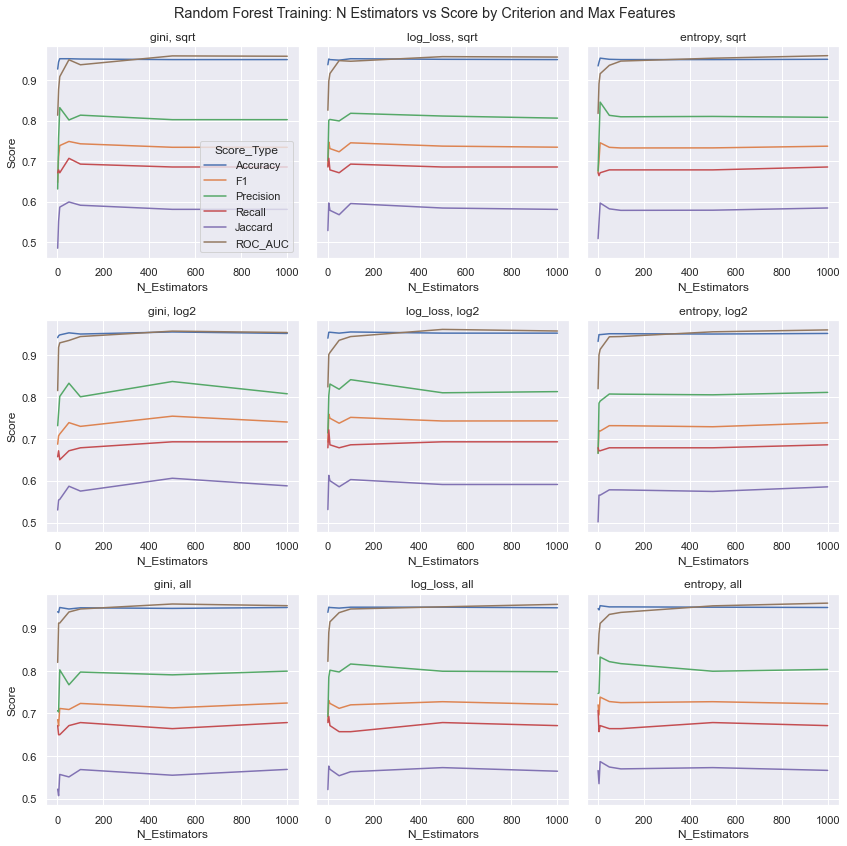

In [34]:
data = rfo_result[['Criterion', 'N_Estimators', 'Max_Features', 'Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard', 'ROC_AUC']]
data = data.melt(id_vars=['Criterion', 'N_Estimators', 'Max_Features'], var_name='Score_Type', value_name='Score')

n_row, n_col = len(max_features), len(criterion)
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4), sharey='row')
fig.suptitle('Random Forest Training: N Estimators vs Score by Criterion and Max Features')
for row in range(n_row):
    for col in range(n_col):
        ax = axes[row][col]
        sns.lineplot(x='N_Estimators', y='Score', hue='Score_Type', 
                     data=data.loc[(data.Criterion==criterion[col]) & (data.Max_Features==max_features[row])], ax=ax)
        ax.set_title('{}, {}'.format(criterion[col], max_features[row])) 
        if col > 0 or row > 0:
            ax.legend().set_visible(False)
#axes[0][3].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(pad=1.2)
plt.show()

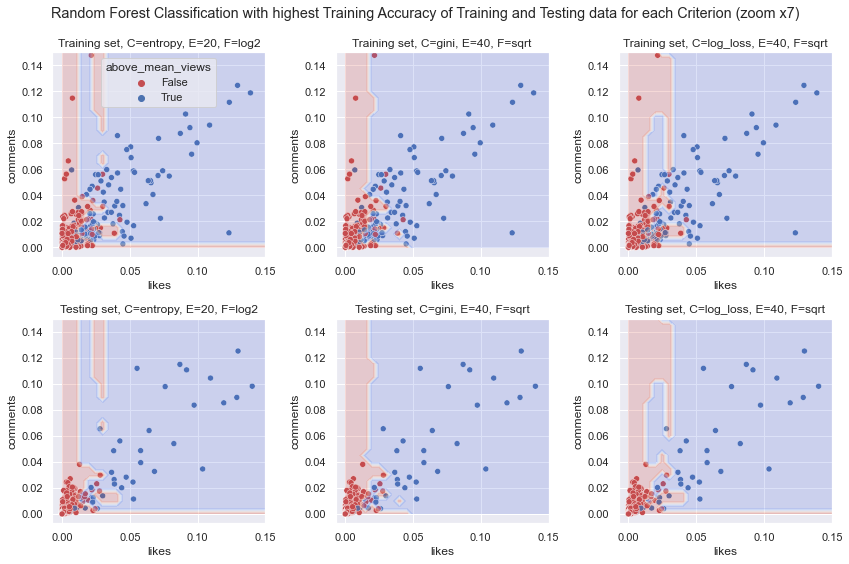

In [50]:
data = [train, test]
best_param_by_criterion = rfo_result.loc[rfo_result.groupby('Criterion')['Accuracy'].idxmax()]
mesh_density = .005
zoom = 7

n_row, n_col = len(data), len(criterion)
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4))
fig.suptitle('Random Forest Classification with highest Training Accuracy of Training and Testing data for each Criterion (zoom x{})'.format(zoom))
for col in range(n_col):
    parameter = best_param_by_criterion.iloc[col]
    ml = RandomForestClassifier(criterion=parameter.Criterion, n_estimators=parameter.N_Estimators, max_features=parameter.Max_Features)
    ml.fit(train_features.values, train_target)
    for row in range(n_row):
        ax = axes[row][col]
        sns.scatterplot(x=feature_names[0], y=feature_names[1], 
                        hue=target_name, palette={True:'b', False:'r'},
                        data=data[row], ax=ax)
        x_min, x_max = train_features[feature_names[0]].min() , train_features[feature_names[0]].max() 
        y_min, y_max = train_features[feature_names[1]].min(), train_features[feature_names[1]].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_density), np.arange(y_min, y_max, mesh_density))
        decision_area = ml.predict(np.c_[xx.ravel(), yy.ravel()])
        decision_area = decision_area.reshape(xx.shape)
        ax.contourf(xx, yy, decision_area, cmap=plt.cm.coolwarm_r, alpha=0.2)
        ax.set(xlim=ax_limit/zoom, ylim=ax_limit/zoom)
        ax.set_title('{}, C={}, E={}, F={}'.format(data[row].name, parameter.Criterion, 
                                                  parameter.N_Estimators, parameter.Max_Features))
        if col > 0 or row > 0: 
            ax.legend().set_visible(False)
plt.tight_layout(pad=1.2)
plt.show()

## 4. SVC

In [42]:
model = SVC()
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
c = np.array(range(0, 100, 10))
c[0] = 1

param_grid = dict(kernel=kernel, C=c, gamma=gamma)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, 
                           scoring=scoring, error_score=0, refit=main_scoring) #, return_train_score=True
grid_search = grid_search.fit(train_features, train_target)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Fram

In [43]:
svc_result = pd.DataFrame(grid_search.cv_results_)
svc_result = svc_result[['param_kernel', 'param_C', 'param_gamma', 'mean_test_accuracy', 'rank_test_accuracy', 
                         'mean_test_f1', 'rank_test_f1', 'mean_test_precision', 'rank_test_precision', 'mean_test_recall', 
                         'rank_test_recall', 'mean_test_jaccard', 'rank_test_jaccard', 'mean_test_roc_auc','rank_test_roc_auc']]
svc_result.rename(columns={'param_kernel': 'Kernel', 'param_C': 'C', 'param_gamma': 'Gamma', 
                           'mean_test_accuracy' : 'Accuracy', 'rank_test_accuracy' : 'Rank_Accuracy', 'mean_test_f1':'F1', 'rank_test_f1':'Rank_F1', 
                           'mean_test_precision':'Precision', 'rank_test_precision':'Rank_Precision', 'mean_test_recall':'Recall', 'rank_test_recall':'Rank_Recall', 
                           'mean_test_jaccard':'Jaccard', 'rank_test_jaccard':'Rank_Jaccard', 'mean_test_roc_auc':'ROC_AUC', 'rank_test_roc_auc':'Rank_ROC_AUC'}, inplace=True)
svc_result.sort_values('Rank_Accuracy').head(10)

,Kernel,C,Gamma,Accuracy,Rank_Accuracy,F1,Rank_F1,Precision,Rank_Precision,Recall,Rank_Recall,Jaccard,Rank_Jaccard,ROC_AUC,Rank_ROC_AUC
26,rbf,30,scale,0.948936,1,0.680171,1,0.919524,43,0.544828,15,0.520060,1,0.855170,68
9,poly,10,scale,0.948936,1,0.677779,2,0.927949,39,0.538177,17,0.518237,2,0.967689,58
33,poly,40,scale,0.948227,3,0.675031,10,0.917115,46,0.538177,17,0.515441,8,0.968073,53
18,rbf,20,scale,0.948227,3,0.675273,8,0.919048,44,0.537931,27,0.513393,16,0.862523,64
17,poly,20,scale,0.948227,3,0.675031,10,0.917115,46,0.538177,17,0.515441,8,0.967882,57
65,poly,80,scale,0.948227,3,0.675031,10,0.917115,46,0.538177,17,0.515441,8,0.968158,51
57,poly,70,scale,0.948227,3,0.675031,10,0.917115,46,0.538177,17,0.515441,8,0.968073,53
10,rbf,10,scale,0.948227,3,0.675273,8,0.919048,44,0.537931,27,0.513393,16,0.916880,62
25,poly,30,scale,0.948227,3,0.675031,10,0.917115,46,0.538177,17,0.515441,8,0.968073,53
49,poly,60,scale,0.948227,3,0.675031,10,0.917115,46,0.538177,17,0.515441,8,0.968018,56


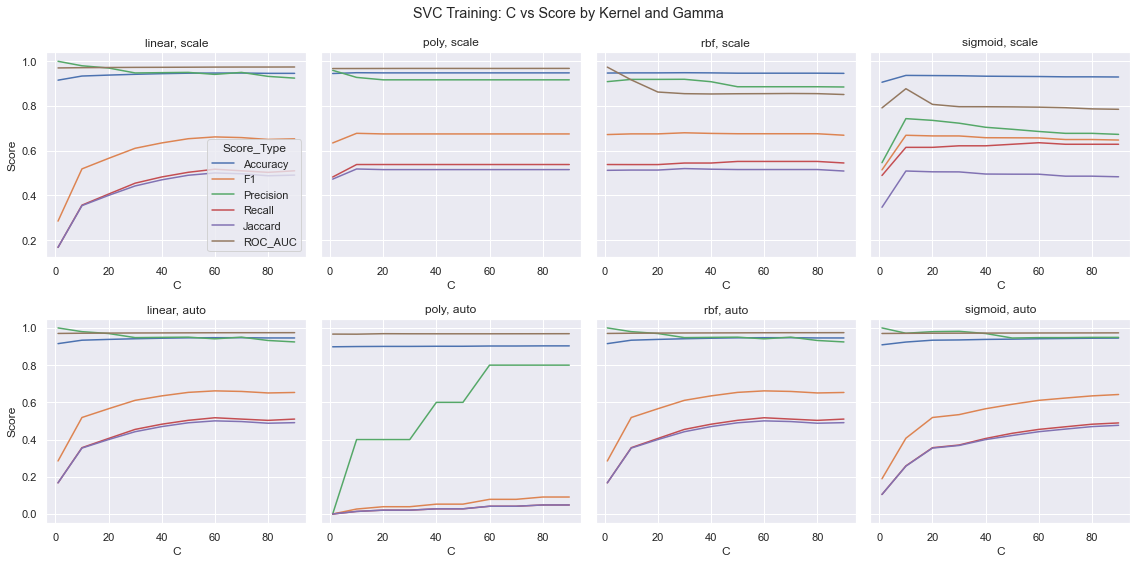

In [44]:
data = svc_result[['Kernel', 'C', 'Gamma', 'Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard', 'ROC_AUC']]
data = data.melt(id_vars=['Kernel', 'C', 'Gamma'], var_name='Score_Type', value_name='Score')

n_row, n_col = len(gamma), len(kernel)
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4), sharey='row')
fig.suptitle('SVC Training: C vs Score by Kernel and Gamma')
for row in range(n_row):
    for col in range(n_col):
        ax = axes[row][col]
        sns.lineplot(x='C', y='Score', hue='Score_Type', 
                     data=data.loc[(data.Kernel==kernel[col]) & (data.Gamma==gamma[row])], ax=ax)
        ax.set_title('{}, {}'.format(kernel[col], gamma[row])) 
        if col > 0 or row > 0:
            ax.legend().set_visible(False)
#axes[0][3].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(pad=1.2)
plt.show()

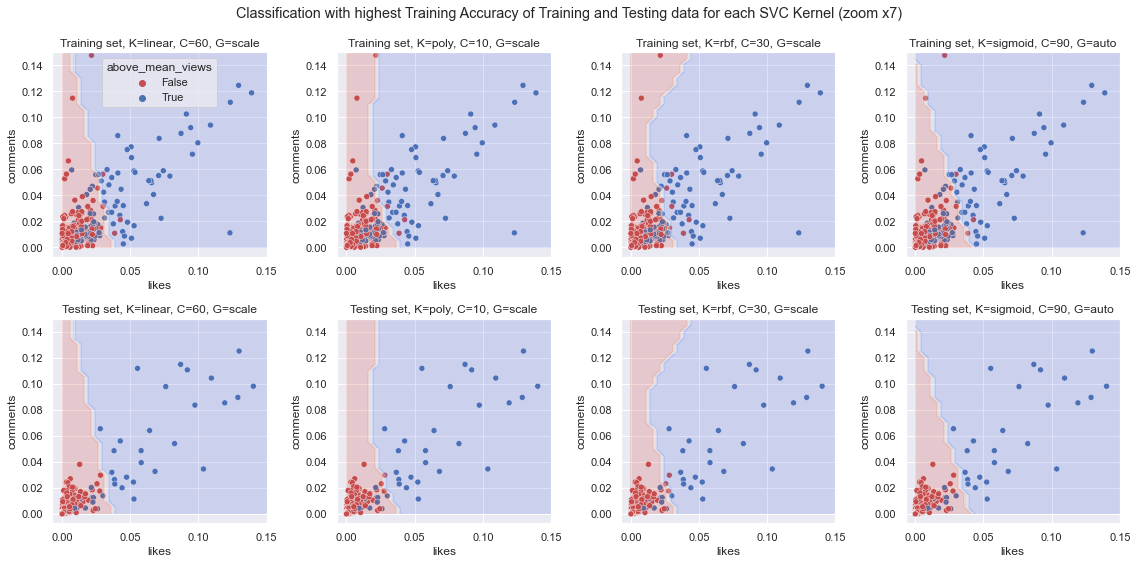

In [46]:
data = [train, test]
best_param_by_kernel = svc_result.loc[svc_result.groupby('Kernel')['Accuracy'].idxmax()]
mesh_density = .005
zoom = 7

n_row, n_col = len(data), len(kernel)
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4))
fig.suptitle('Classification with highest Training Accuracy of Training and Testing data for each SVC Kernel (zoom x{})'.format(zoom))
for col in range(n_col):
    parameter = best_param_by_kernel.iloc[col]
    ml = SVC(kernel=parameter.Kernel, C=parameter.C, gamma=parameter.Gamma)
    ml.fit(train_features.values, train_target)
    for row in range(n_row):
        ax = axes[row][col]
        sns.scatterplot(x=feature_names[0], y=feature_names[1], 
                        hue=target_name, palette={True:'b', False:'r'},
                        data=data[row], ax=ax)
        x_min, x_max = train_features[feature_names[0]].min(), train_features[feature_names[0]].max() 
        y_min, y_max = train_features[feature_names[1]].min(), train_features[feature_names[1]].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_density), np.arange(y_min, y_max, mesh_density))
        decision_area = ml.predict(np.c_[xx.ravel(), yy.ravel()])
        decision_area = decision_area.reshape(xx.shape)
        ax.contourf(xx, yy, decision_area, cmap=plt.cm.coolwarm_r, alpha=0.2)
        ax.set(xlim=ax_limit/zoom, ylim=ax_limit/zoom)
        ax.set_title('{}, K={}, C={}, G={}'.format(data[row].name, parameter.Kernel, 
                                                   parameter.C, parameter.Gamma))
        if col > 0 or row > 0: 
            ax.legend().set_visible(False)
plt.tight_layout(pad=1.2)
plt.show()

## 5. Logistic Regression

In [32]:
model = LogisticRegression()
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky']
penalty = [None, 'l1', 'l2', 'elasticnet']
C = np.array(range(0, 100, 10))
C[0] = 1

param_grid = dict(solver=solver, C=C, penalty=penalty)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, 
                           scoring=scoring, error_score=0, refit=main_scoring ) #, return_train_score=True
grid_search = grid_search.fit(train_features, train_target.values.ravel())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=N

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=N

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was r

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reach

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=N

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

In [20]:
log_result = pd.DataFrame(grid_search.cv_results_)
log_result = log_result[['param_solver', 'param_C', 'param_penalty', 'mean_test_accuracy', 'rank_test_accuracy', 
                         'mean_test_f1', 'rank_test_f1', 'mean_test_precision', 'rank_test_precision', 'mean_test_recall', 
                         'rank_test_recall', 'mean_test_jaccard', 'rank_test_jaccard', 'mean_test_roc_auc','rank_test_roc_auc']]
log_result.rename(columns={'param_solver': 'Solver', 'param_C': 'C', 'param_penalty': 'Penalty', 
                           'mean_test_accuracy' : 'Accuracy', 'rank_test_accuracy' : 'Rank_Accuracy', 'mean_test_f1':'F1', 'rank_test_f1':'Rank_F1', 
                           'mean_test_precision':'Precision', 'rank_test_precision':'Rank_Precision', 'mean_test_recall':'Recall', 'rank_test_recall':'Rank_Recall', 
                           'mean_test_jaccard':'Jaccard', 'rank_test_jaccard':'Rank_Jaccard', 'mean_test_roc_auc':'ROC_AUC', 'rank_test_roc_auc':'Rank_ROC_AUC'}, inplace=True)
log_result.sort_values('Rank_Accuracy').head(10)

,Solver,C,Penalty,Accuracy,Rank_Accuracy,F1,Rank_F1,Precision,Rank_Precision,Recall,Rank_Recall,Jaccard,Rank_Jaccard,ROC_AUC,Rank_ROC_AUC
0,newton-cg,1,None,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974640,3
29,newton-cholesky,10,None,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974640,3
193,lbfgs,80,None,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974640,3
224,liblinear,90,l1,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974556,39
97,lbfgs,40,None,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974640,3
73,lbfgs,30,None,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974640,3
173,newton-cholesky,70,None,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974640,3
197,newton-cholesky,80,None,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974640,3
221,newton-cholesky,90,None,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974640,3
168,newton-cg,70,None,0.953901,1,0.7447,1,0.846506,94,0.670443,1,0.603106,1,0.974640,3


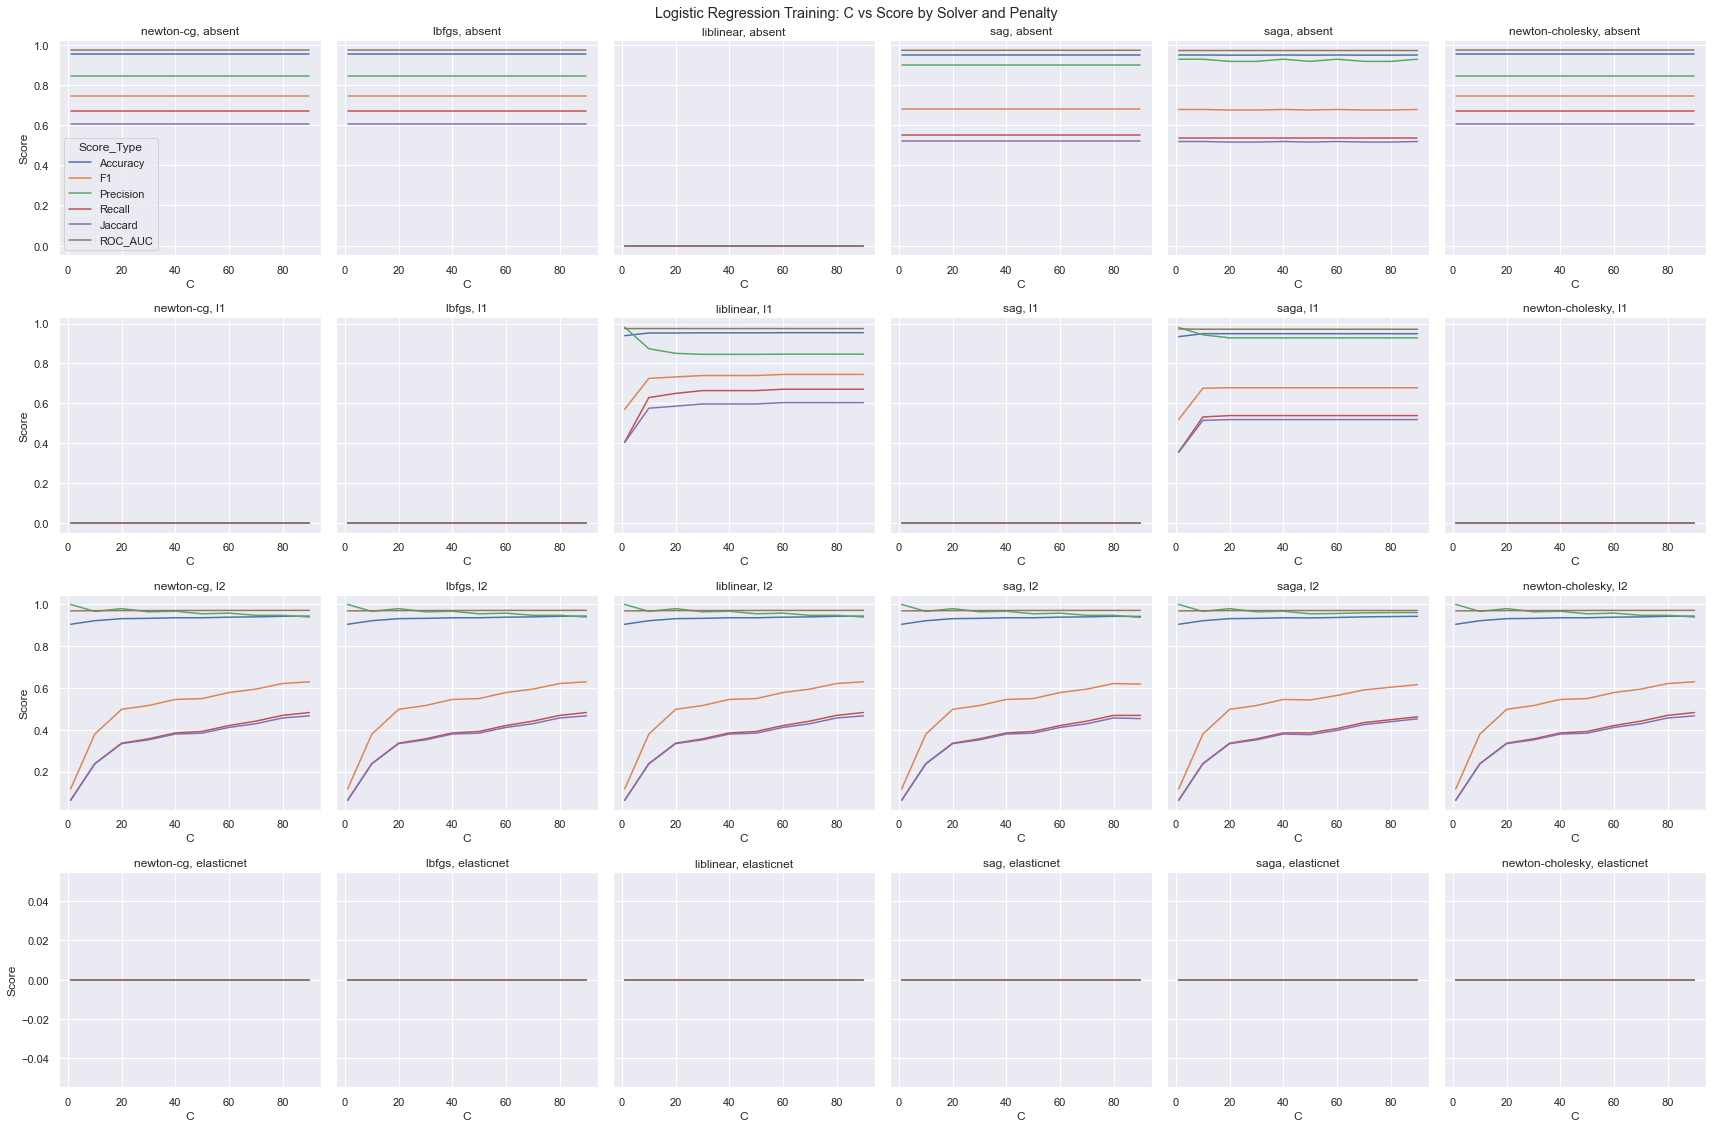

In [21]:
data = log_result[['Solver', 'C', 'Penalty', 'Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard', 'ROC_AUC']]
data = data.melt(id_vars=['Solver', 'C', 'Penalty'], var_name='Score_Type', value_name='Score')
data.Penalty.fillna(value='absent', inplace = True)
penalty = ['absent', 'l1', 'l2', 'elasticnet']

n_row, n_col = len(penalty), len(solver)
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4), sharey='row')
fig.suptitle('Logistic Regression Training: C vs Score by Solver and Penalty')
for row in range(n_row):
    for col in range(n_col):
        ax = axes[row][col]
        sns.lineplot(x='C', y='Score', hue='Score_Type', 
                     data=data.loc[(data.Solver==solver[col]) & (data.Penalty==penalty[row])], ax=ax)
        ax.set_title('{}, {}'.format(solver[col], penalty[row])) 
        if col > 0 or row > 0:
            ax.legend().set_visible(False)
#axes[0][3].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(pad=1.2)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


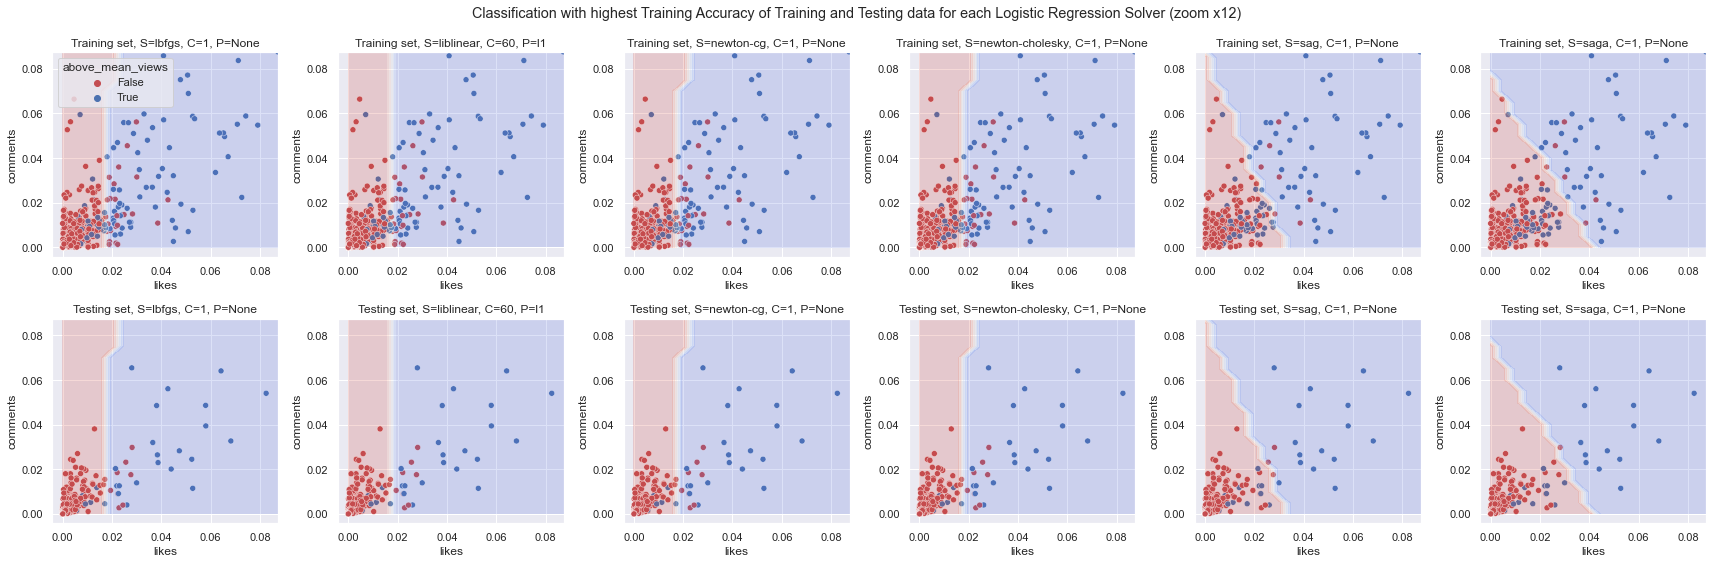

In [31]:
data = [train, test]
best_param_by_solver = log_result.loc[log_result.groupby('Solver')['Accuracy'].idxmax()]
mesh_density = .005
zoom = 12

n_row, n_col = len(data), len(solver)
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*4, n_row*4))
fig.suptitle('Logistic Regression Classification with highest Training Accuracy of Training and Testing data for each Solver (zoom x{})'.format(zoom))
for col in range(n_col):
    parameter = best_param_by_solver .iloc[col]
    ml = LogisticRegression(solver=parameter.Solver, C=parameter.C, penalty=parameter.Penalty)
    ml.fit(train_features.values, train_target.values.ravel())
    for row in range(n_row):
        ax = axes[row][col]
        sns.scatterplot(x=feature_names[0], y=feature_names[1], 
                        hue=target_name, palette={True:'b', False:'r'},
                        data=data[row], ax=ax)
        x_min, x_max = train_features[feature_names[0]].min() , train_features[feature_names[0]].max() 
        y_min, y_max = train_features[feature_names[1]].min(), train_features[feature_names[1]].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_density), np.arange(y_min, y_max, mesh_density))
        decision_area = ml.predict(np.c_[xx.ravel(), yy.ravel()])
        decision_area = decision_area.reshape(xx.shape)
        ax.contourf(xx, yy, decision_area, cmap=plt.cm.coolwarm_r, alpha=0.2)
        ax.set(xlim=ax_limit/zoom, ylim=ax_limit/zoom)
        ax.set_title('{}, S={}, C={}, P={}'.format(data[row].name, parameter.Solver, 
                                                  parameter.C, parameter.Penalty))
        if col > 0 or row > 0: 
            ax.legend().set_visible(False)
plt.tight_layout(pad=1.2)
plt.show()